<h1>Table of Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-Prepare-Data" data-toc-modified-id="Load-and-Prepare-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and Prepare Data</a></span></li><li><span><a href="#Basic-Time-Series-Plots" data-toc-modified-id="Basic-Time-Series-Plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Time Series Plots</a></span><ul class="toc-item"><li><span><a href="#Line-Plots" data-toc-modified-id="Line-Plots-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Line Plots</a></span></li><li><span><a href="#Seasonal-Plots" data-toc-modified-id="Seasonal-Plots-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Seasonal Plots</a></span></li></ul></li><li><span><a href="#Stationarity-Tests" data-toc-modified-id="Stationarity-Tests-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stationarity Tests</a></span></li><li><span><a href="#Time-Series-Decomposition" data-toc-modified-id="Time-Series-Decomposition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Time Series Decomposition</a></span></li><li><span><a href="#Autocorrelation" data-toc-modified-id="Autocorrelation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Autocorrelation</a></span></li><li><span><a href="#Useful-Pandas-Functions-for-Time-Series-Handling" data-toc-modified-id="Useful-Pandas-Functions-for-Time-Series-Handling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Useful Pandas Functions for Time Series Handling</a></span></li></ul></div>

In [1]:
import datetime as dt
import sys
from pathlib import Path

import codebook.EDA as EDA
import codebook.clean as clean
import numpy as np
import pandas as pd
import plotly.express as px
# import plotly.graph_objects as go  # if needed
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('raph-base')

pio.renderers.default = 'notebook' # online only
pio.templates.default = 'plotly_white'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

np.random.seed(666)

In [3]:
print(sys.executable)
print(sys.version)
print(f'Seaborn {sns.__version__}')

C:\Users\r2d4\miniconda3\envs\py3\python.exe
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]
Seaborn 0.11.0


## Load and Prepare Data

In [4]:
# Load from parquet file

filename = 'turnover_data_prepared_monthly.parquet'
rel_path = 'data'

data_raw = pd.read_parquet(Path(rel_path) / filename)
data_raw["date"] = pd.to_datetime(data_raw["date"], format="%Y-%m-%d")

In [5]:
data_raw.head(5)
data_raw.info()

,date,cohort,member,value,value_pct
0,2015-01-31,2015,"44,041.00","5,448,126.50",0.48
1,2015-01-31,2016,1.00,1.00,0.00
2,2015-01-31,2017,1.00,1.00,0.00
3,2015-01-31,2018,1.00,1.00,0.00
4,2015-01-31,2019,1.00,1.00,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       497 non-null    datetime64[ns]
 1   cohort     497 non-null    object        
 2   member     497 non-null    float64       
 3   value      497 non-null    float32       
 4   value_pct  497 non-null    float32       
dtypes: datetime64[ns](1), float32(2), float64(1), object(1)
memory usage: 15.7+ KB


In [6]:
# Aggregate the different turnover cohort data to a total per month

df_total = pd.DataFrame(data_raw.groupby("date")["value"].sum())

# Check
df_total.head()

,value
date,
2015-01-31,"11,294,810.00"
2015-02-28,"9,093,064.00"
2015-03-31,"10,798,992.00"
2015-04-30,"10,195,118.00"
2015-05-31,"10,959,432.00"


## Basic Time Series Plots

### Line Plots

See very end of this notebook for smoothing examples with df.rolling!

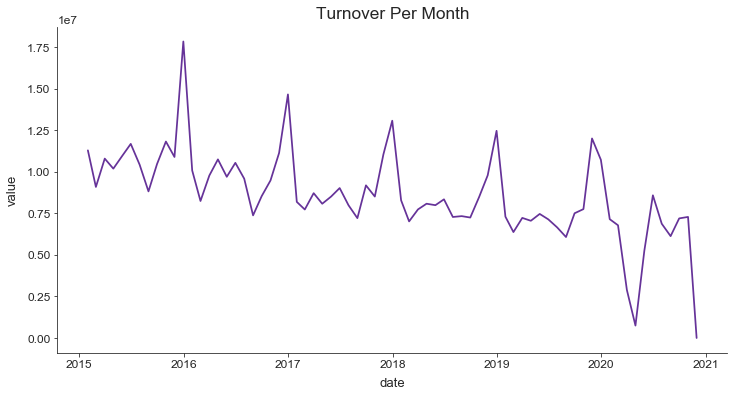

In [8]:
# Can of course easily be done with pandas plotting, here I use seaborn

sns.lineplot(
    data=df_total, 
    x=df_total.index, 
    y="value"
).set_title("Turnover Per Month");

In case I need a **slider** for zooming, I can use Plotly:

In [18]:
# Plotly with Slider

fig=px.line(df_total, x=df_total.index, y="value", title="Monthly Turnover With Slider")
fig.update_xaxes(rangeslider_visible=True)

<img src="pics/line_plot_slider.png">

### Seasonal Plots

Note: I extract the month and year information directly from the datetime index. (Altough it would be nicer to have the months' names for the x-axis.)

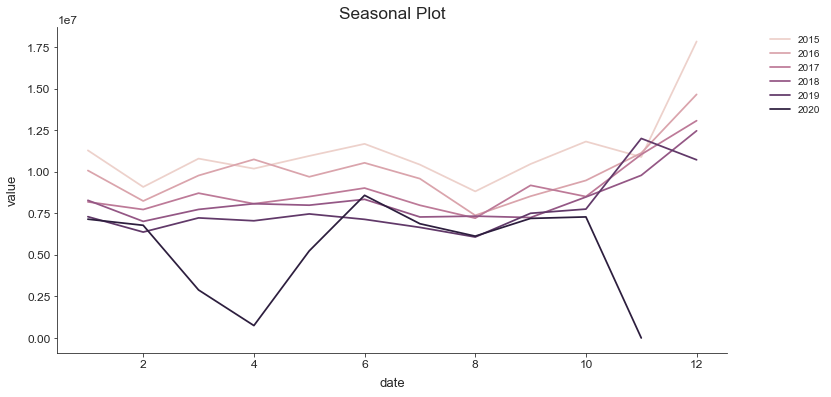

In [9]:
sns.lineplot(
    data=df_total, 
    x=df_total.index.month, 
    y="value",
    hue=df_total.index.year,
    legend="full"
).set_title("Seasonal Plot");


# Move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Next is a **polar plot**, that can easily be done with Plotly. But not if the month column ("theta" param) is numeric. So I map the months integers to names first.

In [19]:
df_total["month"] = df_total.index.month
df_total["month"] = df_total["month"].map(
    {
        1: "Jan",
        2: "Feb",
        3: "Mrz",
        4: "Apr",
        5: "Mai",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Okt",
        11: "Nov",
        12: "Dez"
    }
)

px.line_polar(
    df_total, 
    r="value", 
    theta=df_total["month"], 
    color=df_total.index.year, 
    line_close=True, 
    color_discrete_sequence= ['#0d0887',  '#7201a8', '#bd3786', '#ed7953',  '#fdca26', '#f0f921'],
    title='Polar seasonal plot',
    width=600, 
    height=500
)

<img src="pics/seasonal_polar_plot.png">

## Stationarity Tests

As can bee seen from the plots above, the time series I work with, is not stationary, but has a strong declining trend. 

Nevertheless, there is **two different statistical tests** for checking stationarity:
- **ADF test** (Augmented Dickey-Fuller) - the most commonly used test the Stationarity of the series, where the null hypothesis is the time series possesses a unit root and is non-stationary. So if the p-Value in ADH test is less than the significance level (0.05) we reject the null hypothesis.
- **KPSS test** (Kwiatkowski-Phillips-Schmidt-Shin) - another test for checking the stationarity of a time series. However, the null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

**Null Hypothesis**: The series has a unit root (value of a =1)<br>
**Alternate Hypothesis**: The series has no unit root.

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss

In [22]:
# ADF Test
result = adfuller(
    df_total["value"],
    regression="c",
    autolag="AIC"
)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Series is NOT stationary")
else:
    print("Series is stationary")

ADF Statistic: 0.5941840028209016
p-value: 0.9874713940962364
Series is NOT stationary


In [28]:
# KPSS Test
stats, p, lags, critical_values = kpss(
    df_total["value"],
    regression="c",
    nlags="auto"
)
print(f"KPSS Test Statistics: {stats}")
print(f"p-value: {p}")

if p<0.05:
      print("Series is NOT Stationary")
else:
      print("Series is Stationary")

KPSS Test Statistics: 1.1418567849014405
p-value: 0.01
Series is NOT Stationary


C:\Users\r2d4\miniconda3\envs\py3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning:

p-value is smaller than the indicated p-value



## Time Series Decomposition

Decomposition assumes that a time series can be broken down into a combination of the following components:
- **level** — the average value of the series,
- **trend** — an increasing/decreasing pattern in the series,
- **seasonality** — a repeating short-term cycle in the series,
- **noise** — the random, unexplainable variation.

All time series have the level and noise components, while the trend and seasonality are optional.


There are **two main types** of decomposition models:
- **additive** — it assumes that the components above are added together (linear model). The changes over time are more or less constant.
- **multiplicative** — it assumes that the components are multiplied by each other. Hence, the changes over time are non-linear and not constant, so they can increase/decrease with time. An example could be exponential growth.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
# Because 2020 is not yet complete and ravaged by covid, we only work with data up to 2019
df_total_short = df_total[df_total.index <= "2019-12-31"]

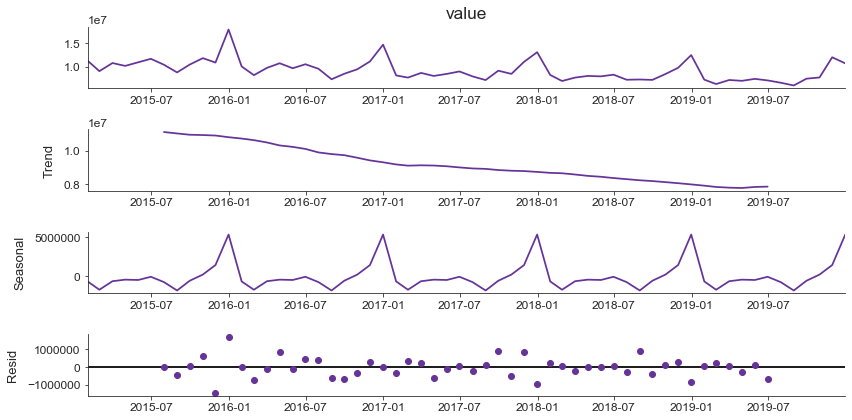

In [13]:
# Additive approach

decompose_add = seasonal_decompose(
    df_total_short["value"], 
    model='additive', 
    period=12
)
decompose_add.plot();

**Note:** For the additive model, the residuals should be close to 0. Here we can see that the model does not fit well.

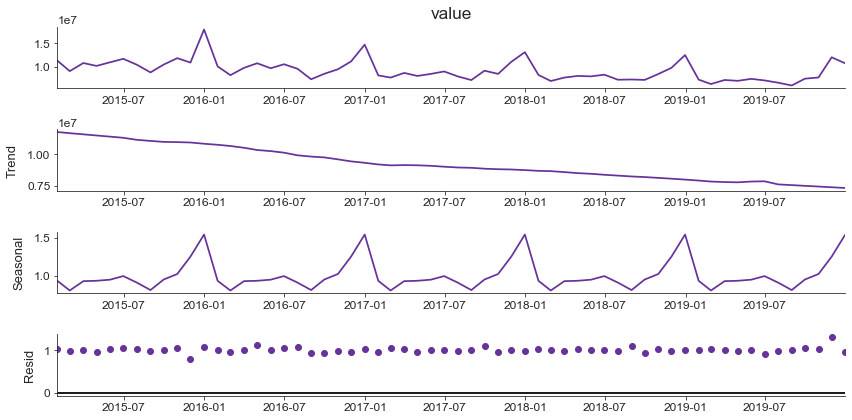

In [64]:
# Multiplicative approach

decompose_mult = seasonal_decompose(
    df_total_short["value"], 
    model='multiplicative', 
    period=12,
    extrapolate_trend="freq" # results in no nan at start and end of trend and resid values
)
decompose_mult.plot();

**Note:** The resudials for the multiplicative model should be close to 1, indicating a good fit.

In [68]:
# Extract the components

df_reconstructed = pd.concat(
    [
        decompose_mult.seasonal,
        decompose_mult.trend,
        decompose_mult.resid,
        decompose_mult.observed
    ],
    axis=1
)
df_reconstructed.columns = ['seasonality', 'trend', 'residual', 'actual_values']
df_reconstructed.head()

,seasonality,trend,residual,actual_values
date,,,,
2015-01-31,0.93,"11,764,553.52",1.03,"11,294,810.00"
2015-02-28,0.80,"11,672,975.55",0.97,"9,093,064.00"
2015-03-31,0.93,"11,581,397.58",1.01,"10,798,992.00"
2015-04-30,0.93,"11,489,819.61",0.95,"10,195,118.00"
2015-05-31,0.95,"11,398,241.64",1.02,"10,959,432.00"


## Autocorrelation

Measuring the correlation between the time series and its lagged values (from previous points in time). Normally, the autocorrelations plots are often used for determining the stationarity of the time series or choosing the hyperparameters of the ARIMA class models.

There are **two types of autocorrelation plots** we can use:

- **autocorrelation function (ACF)** - shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series (mentioned in the decomposition part) while finding the correlations. That is why it’s known as the complete auto-correlation plot.
- **partial autocorrelation function (PACF)** - looks only at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model.

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

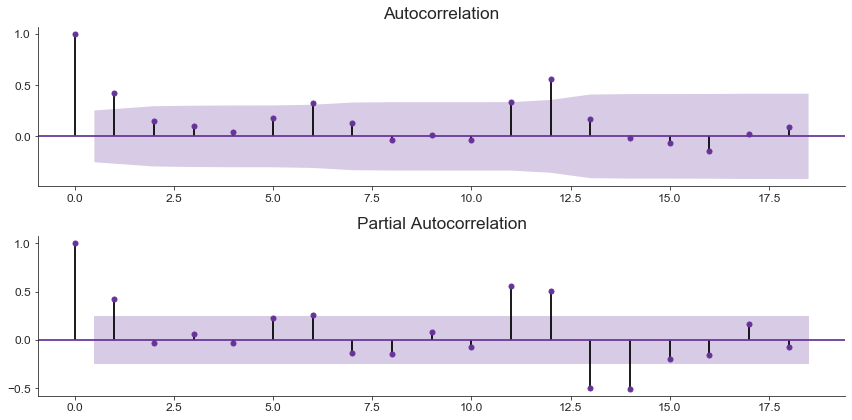

In [14]:
fig, ax = plt.subplots(2)
plot_acf(df_total_short["value"], ax=ax[0])
plot_pacf(df_total_short["value"], ax=ax[1])
plt.tight_layout();

**Note:** In the ACF plot, we can see that there are only a few significant autocorrelations (above the 95% confidence interval, corresponding to the default 5% significance level). There are also some significant autocorrelations in the PACF plot.

In [38]:
# There are some params that can / should be tuned
# Here I can also return the arrays only

from statsmodels.tsa.stattools import acf, pacf

# Calculate ACF and PACF upto 24 lags
acf_50 = acf(df_total_short["value"], nlags=24)
pacf_50 = pacf(df_total_short["value"], nlags=24)

acf_50
pacf_50

array([ 1.        ,  0.42055781,  0.15356674,  0.10146049,  0.03960632,
        0.17818548,  0.32914074,  0.13448479, -0.03386158,  0.01060331,
       -0.03884991,  0.3386141 ,  0.56155812,  0.17026529, -0.01824949,
       -0.06283419, -0.14069789,  0.02315514,  0.09537316, -0.06313384,
       -0.13121213, -0.1095688 , -0.13564165,  0.15550332,  0.29832441])

array([ 1.        ,  0.42768591, -0.0294377 ,  0.06056936, -0.02676297,
        0.22349107,  0.25478965, -0.1395953 , -0.14174513,  0.08691444,
       -0.07033196,  0.55601881,  0.504328  , -0.49574724, -0.50402584,
       -0.19680098, -0.15210883,  0.16546813, -0.06875995, -0.05042361,
        0.21201015,  0.50005755, -0.01292261, -0.9889286 , -6.08006973])

## Useful Pandas Functions for Time Series Handling


In [71]:
# df.resample

df_reconstructed.resample("3M")["trend"].sum().head()

date
2015-01-31   11,764,553.52
2015-04-30   34,744,192.74
2015-07-31   33,849,281.14
2015-10-31   33,001,243.81
2016-01-31   32,515,357.50
Freq: 3M, Name: trend, dtype: float64

In [74]:
# df.diff

df_reconstructed["trend"].diff(2).head()  # Difference every two months

date
2015-01-31           nan
2015-02-28           nan
2015-03-31   -183,155.94
2015-04-30   -183,155.94
2015-05-31   -183,155.94
Name: trend, dtype: float64

In [76]:
# df.pct_change

df_reconstructed["trend"].pct_change().head()  # Note: I have restricted the precision

date
2015-01-31     nan
2015-02-28   -0.01
2015-03-31   -0.01
2015-04-30   -0.01
2015-05-31   -0.01
Name: trend, dtype: float64

In [ ]:
# df.shift

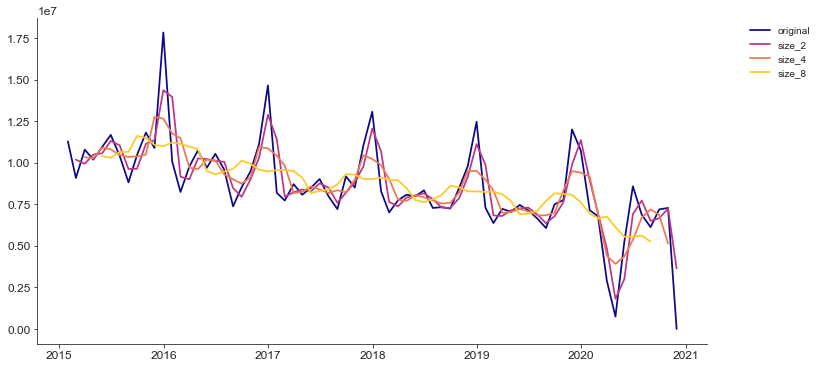

In [95]:
# df.rolling

original = df_total["value"]
size_2 = df_total["value"].rolling(window=2, center=True).mean()
size_4 = df_total["value"].rolling(window=4, center=True).mean()
size_8 = df_total["value"].rolling(window=8, center=True).mean()

fig, ax = plt.subplots()

ax.plot(original, color='#0d0887', label="original")
ax.plot(size_2, color='#bd3786', label="size_2")
ax.plot(size_4, color='#ed7953', label="size_4")
ax.plot(size_8, color='#fdca26', label="size_8")

# Move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Let's say we go for size_4, we can further choose from different window types:

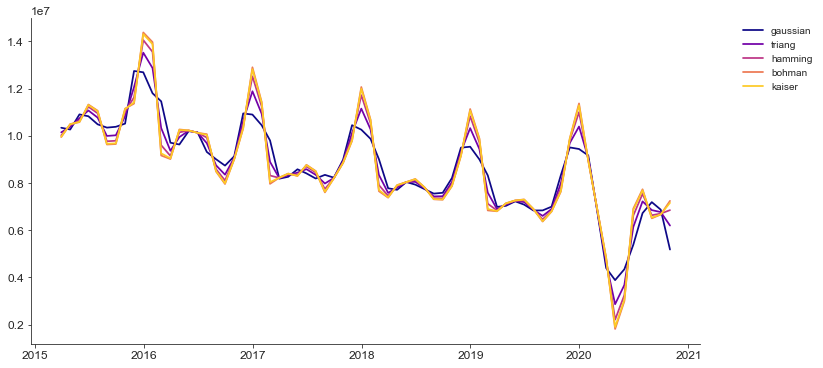

In [94]:
# Note: by default win_type is None and all points are weighed equally
# See docstrings for more details

gaussian = df_total["value"].rolling(window=4, win_type="gaussian", center=True).mean(std=6)  # needs std
triang = df_total["value"].rolling(window=4, win_type="triang", center=True).mean()
hamming = df_total["value"].rolling(window=4, win_type="hamming", center=True).mean()
bohman = df_total["value"].rolling(window=4, win_type="bohman", center=True).mean()
kaiser = df_total["value"].rolling(window=4, win_type="kaiser", center=True).mean(beta=6)  # needs beta

fig, ax = plt.subplots()

ax.plot(gaussian, color='#0d0887', label="gaussian")
ax.plot(triang, color='#7201a8', label="triang")
ax.plot(hamming, color='#bd3786', label="hamming")
ax.plot(bohman, color='#ed7953', label="bohman")
ax.plot(kaiser, color='#fdca26', label="kaiser")
ax.legend();

---